In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from fcn_dataset import CamVidDataset, rev_normalize
import torch
import tqdm

/projectnb/ivc-ml/appledora/condaenvs/.conda/envs/otter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
images_dir = "train/"
labels_dir = "train_labels/"
class_dict_path = "class_dict.csv"
resolution = (240, 240)
class_dict = pd.read_csv("CamVid/" + class_dict_path)
camvid_dataset = CamVidDataset(root='CamVid/', images_dir=images_dir, labels_dir=labels_dir, class_dict_path=class_dict_path, resolution=resolution)
train_loader = torch.utils.data.DataLoader(camvid_dataset, batch_size=4, shuffle=True, num_workers=4)

val_images_dir = "val/"
val_labels_dir = "val_labels/"
val_camvid_dataset = CamVidDataset(root='CamVid/', images_dir=val_images_dir, labels_dir=val_labels_dir, class_dict_path=class_dict_path, resolution=resolution)
val_loader = torch.utils.data.DataLoader(val_camvid_dataset, batch_size=4, shuffle=True, num_workers=4)

test_images_dir = "test/"
test_labels_dir = "test_labels/"
test_camvid_dataset = CamVidDataset(root='CamVid/', images_dir=test_images_dir, labels_dir=test_labels_dir, class_dict_path=class_dict_path, resolution=resolution)
test_loader = torch.utils.data.DataLoader(test_camvid_dataset, batch_size=4, shuffle=True, num_workers=4)


In [4]:
# Example of loading a single sample
image, label = camvid_dataset[0]
print(image.size())
# To visualize or further process, you might want to convert 'label' back to a color image or directly use it for training a segmentation model.
label_vis = label.numpy().astype(np.float32)
label_vis /= 31.
label_vis *= 255.
label_vis = label_vis.astype(np.uint8)
label_vis = Image.fromarray(label_vis)
image_vis = transforms.functional.to_pil_image(rev_normalize(image))

torch.Size([3, 240, 240])


/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.9/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


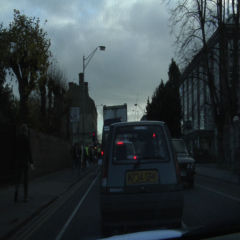

In [5]:
image_vis

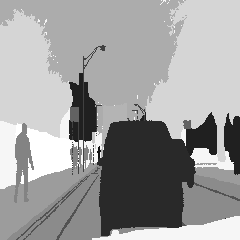

In [6]:
label_vis

In [7]:
from fcn_model import FCN8s
model = FCN8s(num_classes=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
num_classes = 32

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define the loss function and optimizer
def loss_fn(outputs, labels):
    """ 
    In the original paper, the authors mention a per-pixel multinomial logistic loss, which is equivalent to the standard cross-entropy loss.
    """ 
    return torch.nn.CrossEntropyLoss()(outputs, labels)

def calculate_metrics(pred, target, num_classes):
    """ 
    Calculate the pixel accuracy, mean IoU, and frequency weighted IoU.
    """
    pixel_acc = (pred == target).sum() / (target.shape[0] * target.shape[1])
    iou = []
    for i in range(num_classes):
        intersection = ((pred == i) & (target == i)).sum()
        union = ((pred == i) | (target == i)).sum()
        iou.append(intersection / union)
    mean_iou = np.mean(iou)
    freq_iou = np.sum([(target == i).sum() * iou[i] for i in range(num_classes)]) / (target.shape[0] * target.shape[1])
    return pixel_acc, mean_iou, freq_iou

def eval_model(model, dataloader, device, save_pred=False):
    print("Starting eval ....")
    model.eval()
    loss_list = []
    if save_pred:
        pred_list = []
    with torch.no_grad():
        for images, labels in tqdm.tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            if save_pred:
                pred_list.append(predicted.cpu().numpy())
           
        loss = sum(loss_list) / len(loss_list)
        pixel_acc, mean_iou, freq_iou = calculate_metrics(predicted.cpu().numpy(), labels.cpu().numpy(), num_classes)
        print('Pixel accuracy: {:.4f}, Mean IoU: {:.4f}, Frequency weighted IoU: {:.4f}, Loss: {:.4f}'.format(pixel_acc, mean_iou, freq_iou, loss))

    if save_pred:
        pred_list = np.concatenate(pred_list, axis=0)
        np.save('test_pred.npy', pred_list)
    model.train()

    
# Train the model
loss_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm.tqdm(train_loader)):
        images, labels = images.to("cpu"), labels.to("cpu")

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), sum(loss_list)/len(loss_list)))
            loss_list = []
    pixel_acc, mean_iou, freq_iou = calculate_metrics(torch.argmax(outputs, dim=1).cpu().numpy(), labels.cpu().numpy(), num_classes)
    print('Pixel accuracy: {:.4f}, Mean IoU: {:.4f}, Frequency weighted IoU: {:.4f}'.format(pixel_acc, mean_iou, freq_iou))
    # eval the model        
    eval_model(model, val_loader, "cpu")

 11%|█         | 10/93 [02:03<16:10, 11.69s/it]

Epoch [1/10], Step [10/93], Loss: 3.9554


 22%|██▏       | 20/93 [03:57<13:45, 11.31s/it]

Epoch [1/10], Step [20/93], Loss: 1.9185


 32%|███▏      | 30/93 [05:51<11:51, 11.29s/it]

Epoch [1/10], Step [30/93], Loss: 1.3762


 43%|████▎     | 40/93 [07:46<10:20, 11.70s/it]

Epoch [1/10], Step [40/93], Loss: 1.2911


 54%|█████▍    | 50/93 [09:40<08:12, 11.44s/it]

Epoch [1/10], Step [50/93], Loss: 1.2457


 65%|██████▍   | 60/93 [11:29<05:48, 10.57s/it]

Epoch [1/10], Step [60/93], Loss: 1.0321


 75%|███████▌  | 70/93 [13:09<03:50, 10.04s/it]

Epoch [1/10], Step [70/93], Loss: 1.0616


 86%|████████▌ | 80/93 [14:51<02:12, 10.21s/it]

Epoch [1/10], Step [80/93], Loss: 0.9667


 97%|█████████▋| 90/93 [16:32<00:29,  9.89s/it]

Epoch [1/10], Step [90/93], Loss: 1.0319


100%|██████████| 93/93 [16:55<00:00, 10.92s/it]
/scratch/5702050.1.ivcbuyin/ipykernel_215414/868068000.py:17: RuntimeWarning: invalid value encountered in scalar divide
  iou.append(intersection / union)


Pixel accuracy: 178.6958, Mean IoU: nan, Frequency weighted IoU: nan
Starting eval ....


100%|██████████| 25/25 [01:17<00:00,  3.12s/it]


Pixel accuracy: 190.0781, Mean IoU: nan, Frequency weighted IoU: nan, Loss: 0.9698


 11%|█         | 10/93 [01:46<14:21, 10.38s/it]

Epoch [2/10], Step [10/93], Loss: 0.9065


 22%|██▏       | 20/93 [03:30<12:37, 10.38s/it]

Epoch [2/10], Step [20/93], Loss: 0.8709


 32%|███▏      | 30/93 [05:14<11:02, 10.51s/it]

Epoch [2/10], Step [30/93], Loss: 0.8177


 43%|████▎     | 40/93 [06:57<08:47,  9.96s/it]

Epoch [2/10], Step [40/93], Loss: 0.9375


 54%|█████▍    | 50/93 [08:27<06:28,  9.04s/it]

Epoch [2/10], Step [50/93], Loss: 0.7635


 65%|██████▍   | 60/93 [09:57<04:55,  8.94s/it]

Epoch [2/10], Step [60/93], Loss: 0.8139


 75%|███████▌  | 70/93 [11:27<03:25,  8.92s/it]

Epoch [2/10], Step [70/93], Loss: 0.8281


 86%|████████▌ | 80/93 [12:56<01:55,  8.90s/it]

Epoch [2/10], Step [80/93], Loss: 0.7951


 97%|█████████▋| 90/93 [14:25<00:26,  8.91s/it]

Epoch [2/10], Step [90/93], Loss: 0.7812


100%|██████████| 93/93 [14:46<00:00,  9.53s/it]


Pixel accuracy: 171.1708, Mean IoU: nan, Frequency weighted IoU: nan
Starting eval ....


100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


Pixel accuracy: 188.0135, Mean IoU: nan, Frequency weighted IoU: nan, Loss: 0.7556


 11%|█         | 10/93 [01:35<12:33,  9.08s/it]

Epoch [3/10], Step [10/93], Loss: 0.7529


 22%|██▏       | 20/93 [03:05<10:59,  9.03s/it]

Epoch [3/10], Step [20/93], Loss: 0.7812


 32%|███▏      | 30/93 [04:35<09:29,  9.03s/it]

Epoch [3/10], Step [30/93], Loss: 0.7218


 43%|████▎     | 40/93 [06:06<07:58,  9.03s/it]

Epoch [3/10], Step [40/93], Loss: 0.7102


 54%|█████▍    | 50/93 [07:37<06:31,  9.10s/it]

Epoch [3/10], Step [50/93], Loss: 0.7115


 65%|██████▍   | 60/93 [09:07<04:56,  8.98s/it]

Epoch [3/10], Step [60/93], Loss: 0.7128


 75%|███████▌  | 70/93 [10:37<03:28,  9.07s/it]

Epoch [3/10], Step [70/93], Loss: 0.5696


 86%|████████▌ | 80/93 [12:08<01:56,  8.98s/it]

Epoch [3/10], Step [80/93], Loss: 0.6520


 97%|█████████▋| 90/93 [13:37<00:26,  8.91s/it]

Epoch [3/10], Step [90/93], Loss: 0.6999


100%|██████████| 93/93 [13:58<00:00,  9.02s/it]


Pixel accuracy: 184.3458, Mean IoU: nan, Frequency weighted IoU: nan
Starting eval ....


100%|██████████| 25/25 [01:06<00:00,  2.68s/it]


Pixel accuracy: 189.1062, Mean IoU: nan, Frequency weighted IoU: nan, Loss: 0.6952


 11%|█         | 10/93 [01:35<12:37,  9.13s/it]

Epoch [4/10], Step [10/93], Loss: 0.6566


 22%|██▏       | 20/93 [03:05<10:55,  8.98s/it]

Epoch [4/10], Step [20/93], Loss: 0.5885


 32%|███▏      | 30/93 [04:36<09:31,  9.08s/it]

Epoch [4/10], Step [30/93], Loss: 0.6360


 43%|████▎     | 40/93 [06:05<07:53,  8.93s/it]

Epoch [4/10], Step [40/93], Loss: 0.6604


 54%|█████▍    | 50/93 [07:35<06:28,  9.03s/it]

Epoch [4/10], Step [50/93], Loss: 0.6437


 65%|██████▍   | 60/93 [09:05<04:56,  9.00s/it]

Epoch [4/10], Step [60/93], Loss: 0.6554


 75%|███████▌  | 70/93 [10:35<03:27,  9.02s/it]

Epoch [4/10], Step [70/93], Loss: 0.6256


 86%|████████▌ | 80/93 [12:05<01:56,  8.95s/it]

Epoch [4/10], Step [80/93], Loss: 0.6147


 97%|█████████▋| 90/93 [13:34<00:26,  8.89s/it]

Epoch [4/10], Step [90/93], Loss: 0.5991


100%|██████████| 93/93 [13:56<00:00,  8.99s/it]


Pixel accuracy: 162.9083, Mean IoU: nan, Frequency weighted IoU: nan
Starting eval ....


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


Pixel accuracy: 185.6917, Mean IoU: nan, Frequency weighted IoU: nan, Loss: 0.8022


 11%|█         | 10/93 [01:42<13:46,  9.95s/it]

Epoch [5/10], Step [10/93], Loss: 0.7123


 22%|██▏       | 20/93 [03:21<12:11, 10.02s/it]

Epoch [5/10], Step [20/93], Loss: 0.6423


 32%|███▏      | 30/93 [05:01<10:33, 10.05s/it]

Epoch [5/10], Step [30/93], Loss: 0.6077


 42%|████▏     | 39/93 [06:30<08:50,  9.83s/it]